<a href="https://colab.research.google.com/github/akhtarmf/machinelearning/blob/main/ChE788_A4_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ChE 788 Assignment 4 (Complete Dataset)
# Mohammad Akhtar, 001209524

# TensorFlow libraries
import tensorflow as tf
import datetime, os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam, Adadelta, Adamax
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from tensorflow.keras import regularizers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical 
import numpy as np
import matplotlib.pyplot as plt


*Import TensorFlow CIFAR-10 dataset*

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

*Limit CIFAR-10 dataset to animal classes only & verify resultant shapes and sample plot*

Shape of training data:
(30000, 32, 32, 3)
(5000, 6)

Shape of test data:
(6000, 32, 32, 3)
(1000, 6) 



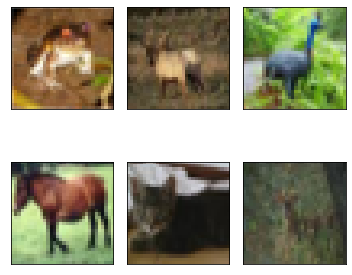

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

x_train = train_images[np.isin(train_labels, [2, 3, 4, 5, 6, 7]).flatten()]
y_train = train_labels[np.isin(train_labels, [2, 3, 4, 5, 6, 7]).flatten()]
x_test = test_images[np.isin(test_labels, [2, 3, 4, 5, 6, 7]).flatten()]
y_test = test_labels[np.isin(test_labels, [2, 3, 4, 5, 6, 7]).flatten()]

x_train = x_train.reshape(-1,32,32,3)
y_train = y_train.reshape(-1,6)
x_test = x_test.reshape(-1,32,32,3)
y_test = y_test.reshape(-1,6)

print("Shape of training data:")
print(x_train.shape)
print(y_train.shape)
print("\nShape of test data:")
print(x_test.shape)
print(y_test.shape,"\n")

plt.figure(figsize=(5,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.tight_layout()    
plt.show()

1. *Experiment setup and the HParams experiment summary*:


1. Number of filters in each CNN layer (HP_NUM_FILTERS1, HP_NUM_FILTERS2, HP_NUM_FILTERS3)
2. Batch size (HP_BAT): optimized for the number of samples processed before the model is updated.
3. Batch Normalization (HP_BATNORM_MOMENT): optimized for 0.50, 0.75, and 0.99 momentum or large, medium, and small batch size, respectively in order to reduce the problem of internal covariate shift offsetting speed and stability.
4. L2 regularization (HP_L2): to prevent overfitting.
5. Epochs (HP_EPOC): optimized for the number of complete passes through the dataset.
6. Dropout (HP_DROPOUT): optimized to decrease overfitting.
7. Optimization algorithm (HP_OPTIMIZER)



In [ ]:
# Parse numbers as floats
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize data
train_images = train_images / 255.0
test_images = test_images / 255.0

HP_NUM_FILTERS1 = hp.HParam('num_filters 1', hp.Discrete([16,32])) 
HP_NUM_FILTERS2 = hp.HParam('num_filters 2', hp.Discrete([32,64]))
HP_NUM_FILTERS3 = hp.HParam('num_filters 3', hp.Discrete([64,128]))
HP_BATNORM_MOMENT = hp.HParam('batnorm', hp.Discrete([0.50, 0.75, 0.99]))
HP_BAT = hp.HParam('bat', hp.Discrete([50, 75, 100]))
HP_L2 = hp.HParam('l2', hp.RealInterval(.001,.01))
HP_EPOC = hp.HParam('epoc', hp.Discrete([10, 25, 50]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([.05, .15, .30]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_FILTERS1,HP_NUM_FILTERS2, HP_NUM_FILTERS3, HP_BATNORM_MOMENT, HP_BAT, HP_L2 ,HP_EPOC, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

2. *Configure 3-block VVGNet convolutional neural network (CNN) model architecture*; Adapt TensorFlow runs to log hyperparameters and metrics

In [ ]:
# 3-block VGGNet architecture

def train_test_model(hparams):
  model = Sequential()
  model.add(Conv2D(hparams[HP_NUM_FILTERS1], kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(hparams[HP_NUM_FILTERS2], kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(hparams[HP_NUM_FILTERS3], kernel_size=(3, 3), activation='relu'))
  model.add(BatchNormalization(momentum=hparams[HP_BATNORM_MOMENT]))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Output
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.add(Dropout(hparams[HP_DROPOUT]))
  
  # Compile the model
  model.compile(
      loss=sparse_categorical_crossentropy,
      optimizer=hparams[HP_OPTIMIZER],
      metrics=['accuracy']
      )
  
  # Fit data to model
  history = model.fit(
      train_images, train_labels,
      batch_size=hparams[HP_BAT],
      epochs=hparams[HP_EPOC],
      verbose=1,
      validation_split=0.25,
      )
  
  loss, accuracy = model.evaluate(test_images, test_labels)

  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

3. *Start runs and log them all under one parent directory & visualize the results in TensorBoard's HParams plugin*

In [ ]:
session_num = 0

for num_filters1 in HP_NUM_FILTERS1.domain.values:
  for num_filters2 in HP_NUM_FILTERS2.domain.values:
    for num_filters3 in HP_NUM_FILTERS3.domain.values:
      for batnorm in HP_BATNORM_MOMENT.domain.values:
        for bat in HP_BAT.domain.values:
          for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
            for epoc in HP_EPOC.domain.values:
              for dropout in HP_DROPOUT.domain.values:
                for optimizer in HP_OPTIMIZER.domain.values:
                  hparams = {
                      HP_NUM_FILTERS1: num_filters1,
                      HP_NUM_FILTERS2: num_filters2,
                      HP_NUM_FILTERS3: num_filters3,
                      HP_BATNORM_MOMENT: batnorm,
                      HP_BAT: bat,
                      HP_L2: l2,
                      HP_EPOC: epoc,
                      HP_DROPOUT: dropout,
                      HP_OPTIMIZER: optimizer,
                      }
                  run_name = "run-%d" % session_num
                  print('--- Starting trial: %s' % run_name)
                  print({h.name: hparams[h] for h in hparams})
                  run('logs/hparam_tuning/' + run_name, hparams)
                  session_num += 1


--- Starting trial: run-0
{'num_filters 1': 16, 'num_filters 2': 32, 'num_filters 3': 64, 'batnorm': 0.5, 'bat': 50, 'l2': 0.001, 'epoc': 10, 'dropout': 0.05, 'optimizer': 'adam'}
Epoch 1/10
750/750 [==============================] - 3s 4ms/step - loss: 2.1482 - accuracy: 0.4541 - val_loss: 1.3830 - val_accuracy: 0.5137
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 1.8314 - accuracy: 0.5621 - val_loss: 1.1466 - val_accuracy: 0.6013
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 1.7004 - accuracy: 0.6091 - val_loss: 1.0625 - val_accuracy: 0.6329
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 1.5651 - accuracy: 0.6417 - val_loss: 1.2753 - val_accuracy: 0.5834
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 1.5167 - accuracy: 0.6657 - val_loss: 1.0261 - val_accuracy: 0.6564
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 1.4189 - accuracy: 0.6870 - val_loss

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs